In [ ]:
#@title Install yahoo finance api
try:
  import yfinance as yf
except:
  !pip install yfinance

In [ ]:
#@title Import needed Libraries
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error


In [ ]:
#@title build a function to fetch stock data from yahoo finance
def get_stock_data(tickers, start_date, end_date):
  """
  Usage
  =====
  Fetch historical stock data for a given ticker symbol and date range.

  Parameters:
  -----------
  - tickers: str
  Ticker symbol(s) of the stock(s) (e.g. 'MSFT' for Apple Inc.)
  - start_date: date
  Start date in the format "YYYY-MM-DD"
  - end_date: date
  End date in the format "YYYY-MM-DD".

  Returns:
  -------
  A pandas DataFrame containing historical stock data.
  """

  try:
    data = yf.download(tickers = tickers, start = start_date, end=end_date)
    return data

  except Exception as e:
    print(f"An error occured: {str(e)}")
    return None

In [ ]:
data = get_stock_data("AAPL", '2020-01-01', '2024-04-29')
data.shape

[*********************100%%**********************]  1 of 1 completed


(1087, 6)

In [ ]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,74.059998,75.150002,73.797501,75.087502,73.059425,135480400
2020-01-03,74.287498,75.144997,74.125000,74.357498,72.349129,146322800
2020-01-06,73.447502,74.989998,73.187500,74.949997,72.925621,118387200
2020-01-07,74.959999,75.224998,74.370003,74.597504,72.582649,108872000
2020-01-08,74.290001,76.110001,74.290001,75.797501,73.750237,132079200


In [ ]:
from statsmodels.tsa.stattools import adfuller

def ad_test(dataset):
  dftest = adfuller(dataset, autolag = "AIC")
  print("1. ADF : ", dftest[0])
  print("2. p-value : ", dftest[1])
  print("3. Num Of Lags : ", dftest[2])
  print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation : ", dftest[3])
  print("5. Critical Values : ")
  for key, val in dftest[4].items():
    print("\t", key, ": ", val)

In [ ]:
ad_test(data['Close'])

1. ADF :  -1.9834294881419896
2. p-value :  0.29388561824309467
3. Num Of Lags :  0
4. Num Of Observations Used For ADF Regression and Critical Values Calculation :  1086
5. Critical Values : 
	 1% :  -3.4363857496063455
	 5% :  -2.8642050392821794
	 10% :  -2.5681889563132314


##### since the p-value is greater than 0.05 we can conclude that the data is not stationary

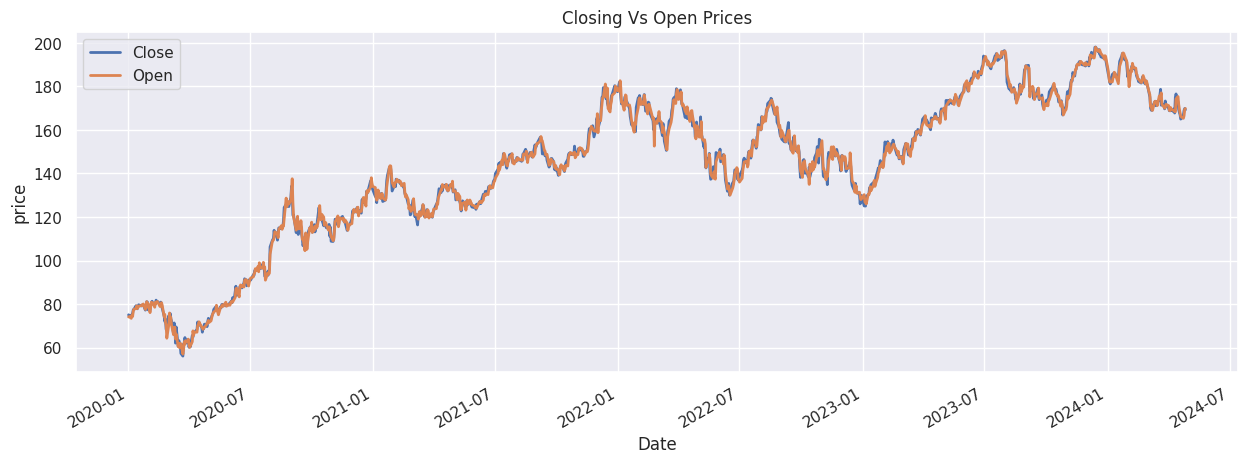

In [ ]:
#@title closing price
sns.set(rc = {'figure.figsize': (15, 5)})
data.Close.plot(linewidth =2)
data.Open.plot(linewidth =2)

# label chart
plt.ylabel('price')
plt.title('Closing Vs Open Prices')
plt.legend();

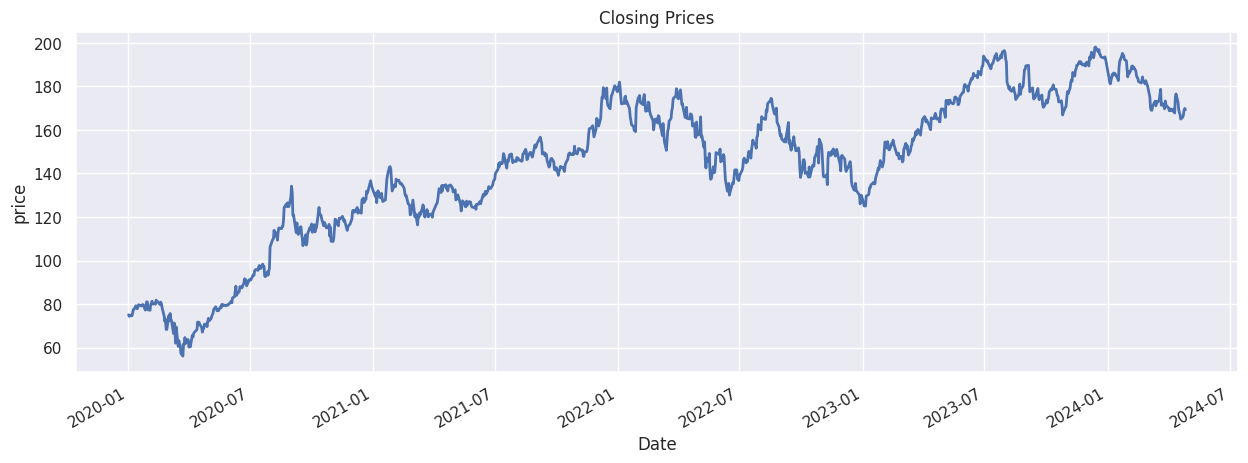

In [ ]:
#@title closing price
sns.set(rc = {'figure.figsize': (15, 5)})
data.Close.plot(linewidth =2)

# label chart
plt.ylabel('price')
plt.title('Closing Prices');

<Axes: title={'center': 'Weekly Rolling Average'}, xlabel='Date', ylabel='PPrice'>

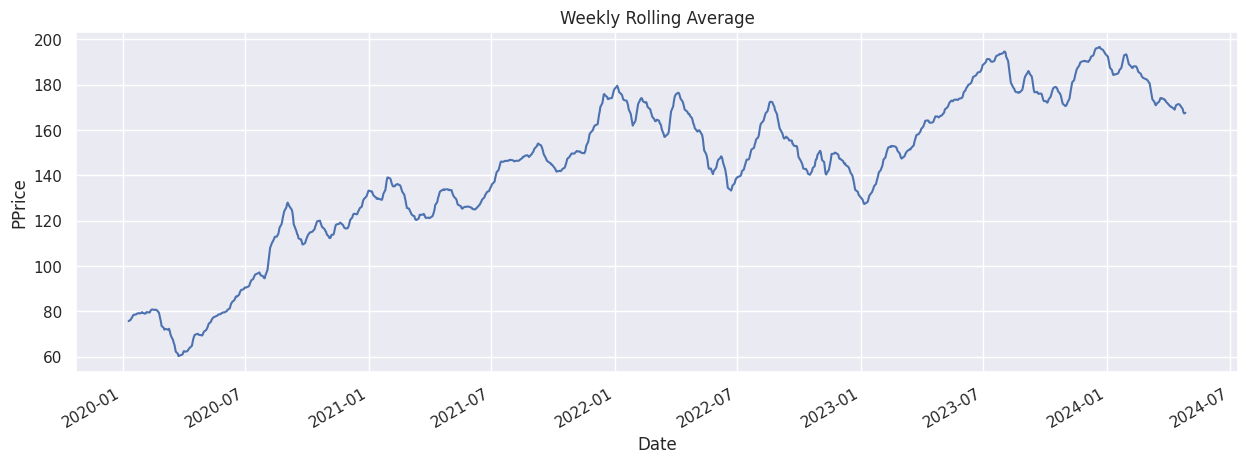

In [ ]:
data["Close"].rolling(7).mean().plot(ylabel="PPrice", title="Weekly Rolling Average")

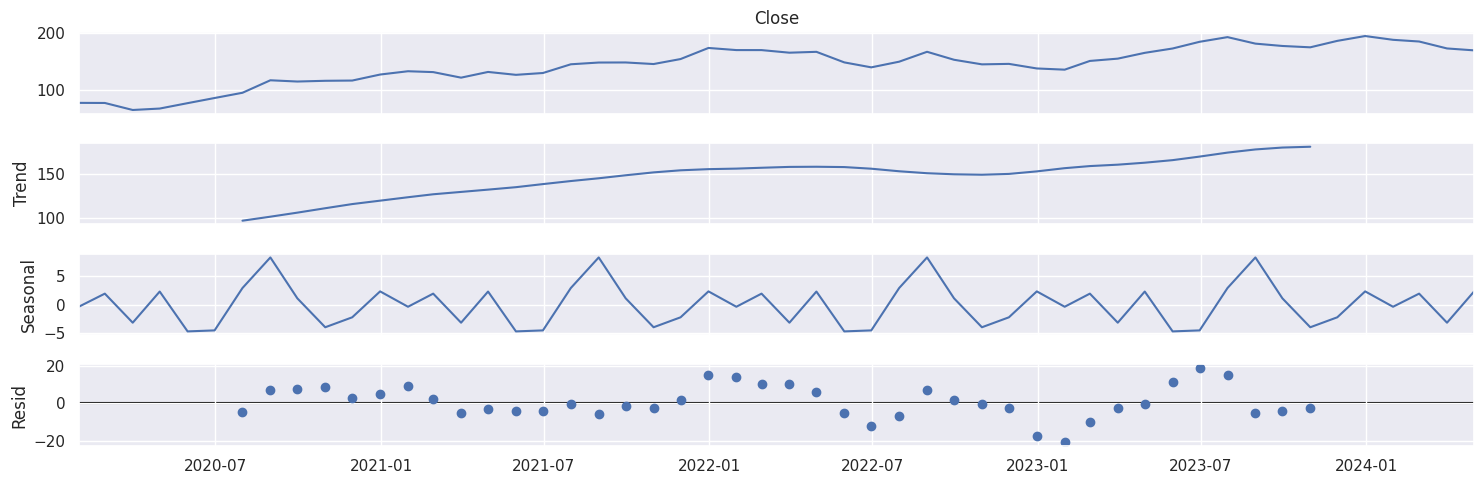

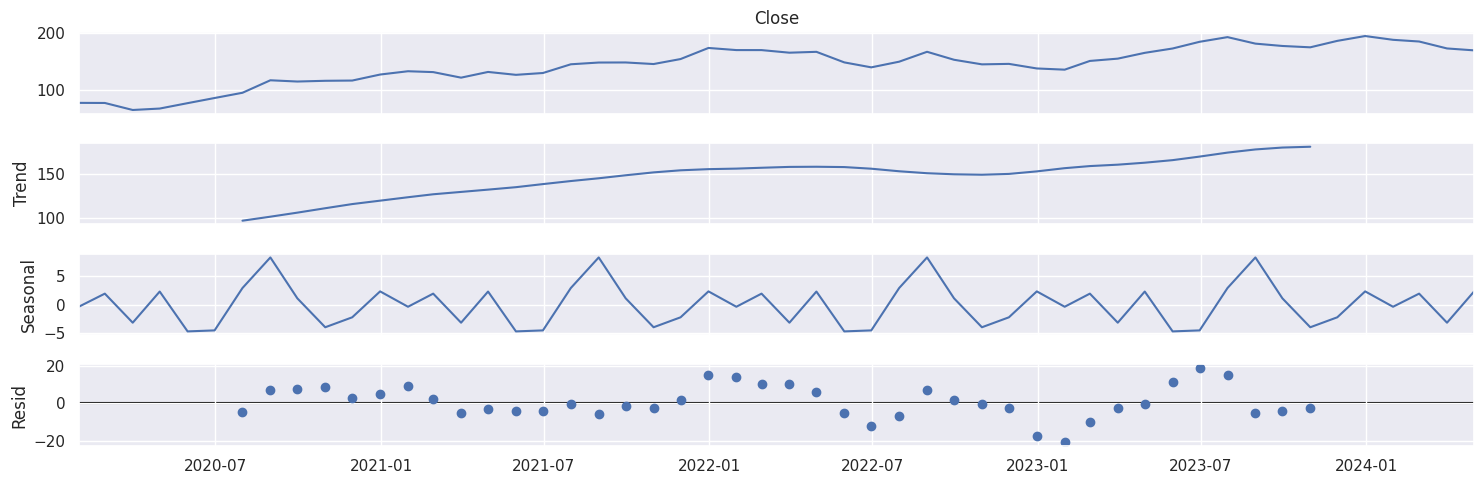

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
monthly_data = data['Close'].resample('M').mean()
# Perform seasonal decomposition on the monthly data
result = seasonal_decompose(monthly_data, period=12)

# Plot the decomposed components
result.plot()

In [ ]:
#@title Check for volatility
data['price change'] = data['Close'].pct_change() * 100
data.head()

,Open,High,Low,Close,Adj Close,Volume,price change
Date,,,,,,,
2020-01-02,74.059998,75.150002,73.797501,75.087502,73.059425,135480400,NaN
2020-01-03,74.287498,75.144997,74.125000,74.357498,72.349129,146322800,-0.972204
2020-01-06,73.447502,74.989998,73.187500,74.949997,72.925621,118387200,0.796825
2020-01-07,74.959999,75.224998,74.370003,74.597504,72.582649,108872000,-0.470305
2020-01-08,74.290001,76.110001,74.290001,75.797501,73.750237,132079200,1.608629


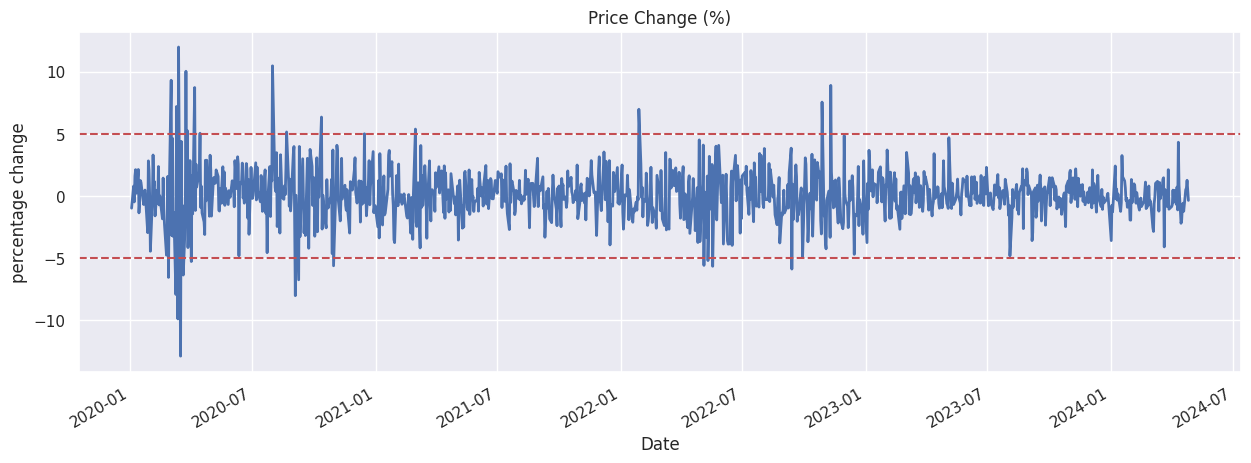

In [ ]:
#@title price change
data['price change'].plot(linewidth =2)
plt.axhline(5, color = 'r', linestyle = '--')
plt.axhline(-5, color = 'r', linestyle = '--')
# label chart
plt.ylabel('percentage change')
plt.title('Price Change (%)');

In [ ]:
#@title Prepare the dataset for modelling
X = data['Close']
# Convert the index to a datetime object
X.index = pd.to_datetime(X.index)
X.head()

Date
2020-01-02    75.087502
2020-01-03    74.357498
2020-01-06    74.949997
2020-01-07    74.597504
2020-01-08    75.797501
Name: Close, dtype: float64

In [ ]:
# @title Split dataset
cutoff = int(0.9 * X.shape[0])
train = X.iloc[:cutoff]
test = X.iloc[cutoff:]

print('Training dataset shape:', train.shape)
print('Testing dataset shape:', test.shape)

Training dataset shape: (978,)
Testing dataset shape: (109,)


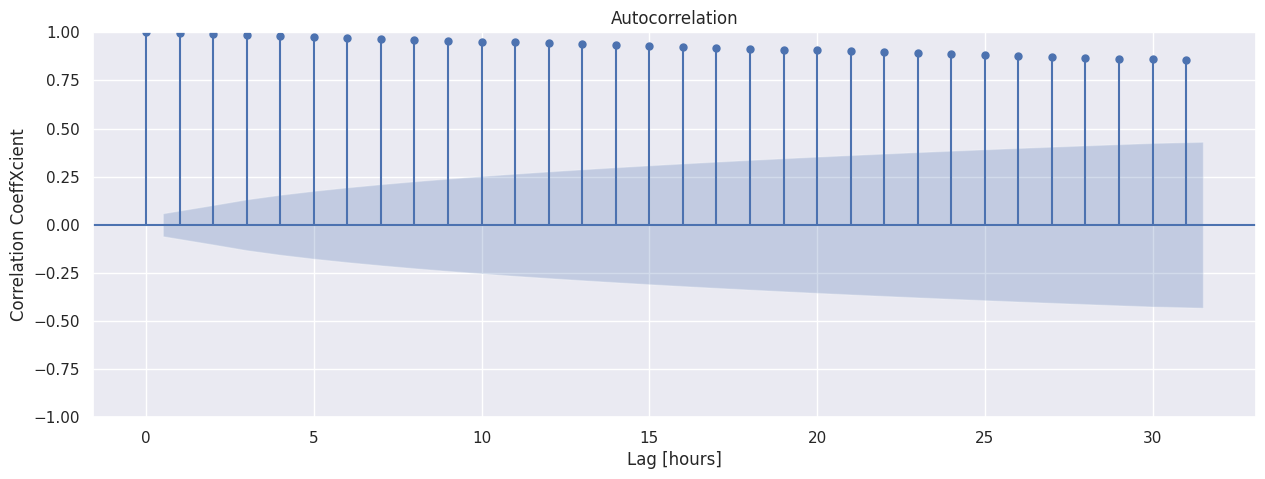

In [ ]:
plot_acf(X)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation CoeffXcient");

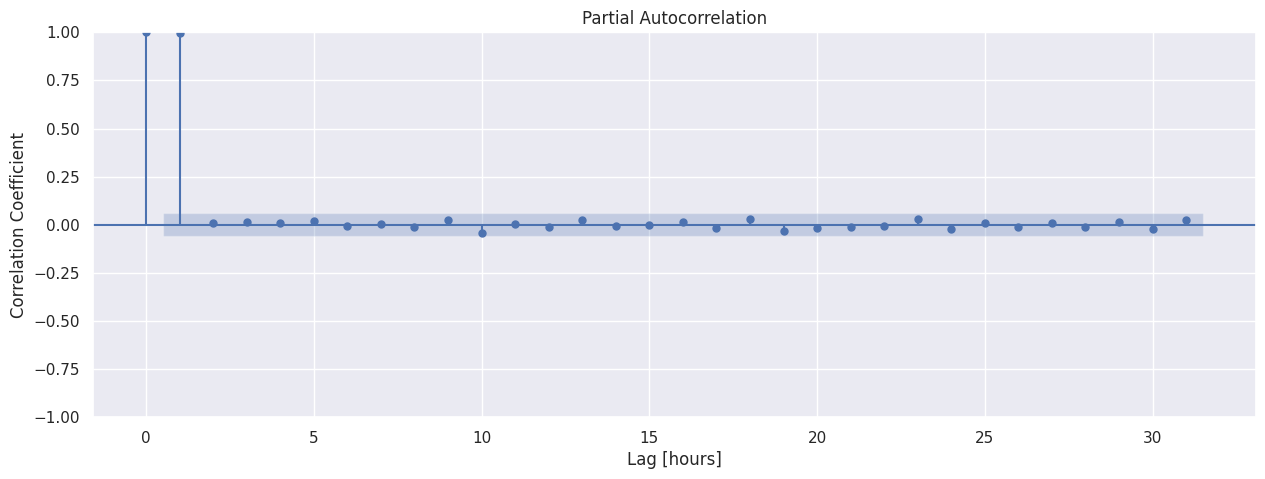

In [ ]:
plot_pacf(X)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient");

In [ ]:
train_mean=train.mean()
pred_baseline=[train_mean] * len(train)
mae_baseline = mean_absolute_error(train,pred_baseline)
print("Mean Closing Price:", round(train_mean, 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean Closing Price: 139.31
Baseline MAE: 25.89


In [ ]:
p_params = range(0, 3, 1)
q_params = range(0, 3, 1)

In [ ]:
# Create dictionary to store MAEs
mae_grid = dict()
# Outer loop: Iterate through possible values for `p`
for p in p_params:
    # Create key-value pair in dict. Key is `p`, value is empty list.
    mae_grid[p] = []
    # Inner loop: Iterate through possible values for `q`
    for q in q_params:
        # Combination of hyperparameters for model
        order = (p, 1, q)
        # Note start time
        start_time = time.time()
        # Train model
        model = ARIMA(train, order=order).fit()
        # Calculate model training time
        elapsed_time = round(time.time() - start_time, 2)
        print(f"Trained ARIMA {order} in {elapsed_time} seconds.")
        # Generate in-sample (training) predictions
        pred = model.predict()
        # Calculate training MAE
        mae = mean_absolute_error(train,pred)
        # Append MAE to list in dictionary
        mae_grid[p].append(mae)

print()
print(mae_grid)

Trained ARIMA (0, 1, 0) in 0.06 seconds.
Trained ARIMA (0, 1, 1) in 0.25 seconds.
Trained ARIMA (0, 1, 2) in 0.32 seconds.
Trained ARIMA (1, 1, 0) in 0.12 seconds.
Trained ARIMA (1, 1, 1) in 0.37 seconds.
Trained ARIMA (1, 1, 2) in 0.47 seconds.
Trained ARIMA (2, 1, 0) in 0.08 seconds.
Trained ARIMA (2, 1, 1) in 0.59 seconds.
Trained ARIMA (2, 1, 2) in 0.86 seconds.

{0: [2.069304429192724, 2.0670844769070276, 2.066134260937505], 1: [2.067265335237662, 2.066345120291275, 2.066207007656612], 2: [2.0661556095775095, 2.0662007660215806, 2.066189348147302]}


In [ ]:
mae_df = pd.DataFrame(mae_grid)
mae_df.round(4)

,0,1,2
0,2.0693,2.0673,2.0662
1,2.0671,2.0663,2.0662
2,2.0661,2.0662,2.0662


##### We will choose the order for the ARIMA model to be  (2,1,0)  because it has a lower mean absolute error and a lower elapsed time

Text(0.5, 1.0, 'ARMA Grid Search (Criterion: MAE')

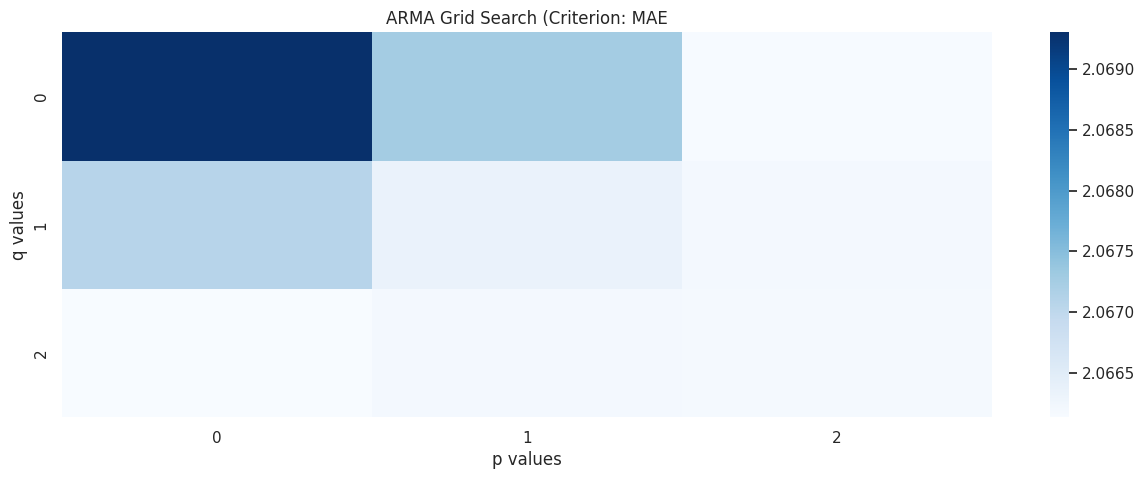

In [ ]:
sns.heatmap(mae_df, cmap="Blues")
plt.xlabel("p values")
plt.ylabel("q values")
plt.title("ARMA Grid Search (Criterion: MAE")

### Using walk forward validation method to predict for the Test data

In [ ]:
# ARIMA model initialization and fitting
order = (2, 1, 0)
model = ARIMA(train, order=order)
fitted_model = model.fit()

# Walk-forward validation
history = list(train)
predictions = []
for t in range(len(test)):
    model = ARIMA(history, order=order)
    fitted_model = model.fit()
    output = fitted_model.forecast()
    yhat = output
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)  # Append the value directly, not the entire observation object

In [ ]:
import numpy as np
# Assuming predictions is a list and test is a Pandas Series
predictions_flat = np.ravel(predictions)
df_predictions = pd.DataFrame({"y_test": test.values, "y_pred_wfv": predictions_flat},index= test.index)

# Output the DataFrame
print(df_predictions)

mae = mean_absolute_error(test, predictions)
print("The mean absolute error is ",  mae)


                y_test  y_pred_wfv
Date                              
2023-11-20  191.449997  189.651368
2023-11-21  190.639999  191.383777
2023-11-22  191.309998  190.630816
2023-11-24  189.970001  191.302724
2023-11-27  189.789993  190.006255
...                ...         ...
2024-04-22  165.839996  165.078969
2024-04-23  166.899994  165.854668
2024-04-24  169.020004  166.851925
2024-04-25  169.889999  168.937040
2024-04-26  169.300003  169.823643

[109 rows x 2 columns]
The mean absolute error is  1.6897860992958302


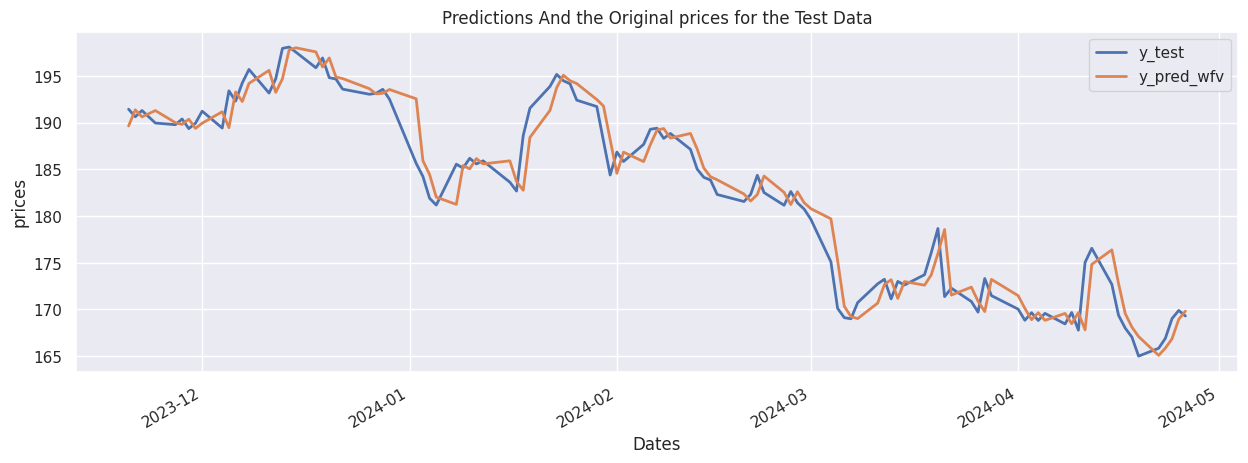

In [ ]:
sns.set(rc = {'figure.figsize': (15, 5)})
df_predictions['y_test'].plot(linewidth =2)
df_predictions['y_pred_wfv'].plot(linewidth =2)

# label chart
plt.xlabel('Dates')
plt.ylabel('prices')
plt.title('Predictions And the Original prices for the Test Data')
plt.legend();

### Predicting for the Test data

In [ ]:
start = len(train)
end = len(train)+len(test)-1
pred = fitted_model.predict(start=start, end=end)
# Create a DataFrame from the predictions with the correct index
pred_df = pd.DataFrame(pred, index=data.index[start:end+1], columns=['predicted_values'])

y_test= test
# Concatenate the predicted values DataFrame with the test values DataFrame
result_df = pd.concat([y_test.rename('actual_values'), pred_df], axis=1)

# Print the combined DataFrame
print(result_df)

mae = mean_absolute_error(y_test, pred)
print("The mean absolute error is ", mae)

            actual_values  predicted_values
Date                                       
2023-11-20     191.449997        189.657685
2023-11-21     190.639999        191.399145
2023-11-22     191.309998        190.629520
2023-11-24     189.970001        191.306167
2023-11-27     189.789993        189.996047
...                   ...               ...
2024-04-22     165.839996        165.077970
2024-04-23     166.899994        165.855021
2024-04-24     169.020004        166.852878
2024-04-25     169.889999        168.937770
2024-04-26     169.300003        169.823643

[109 rows x 2 columns]
The mean absolute error is  1.6876652528687945


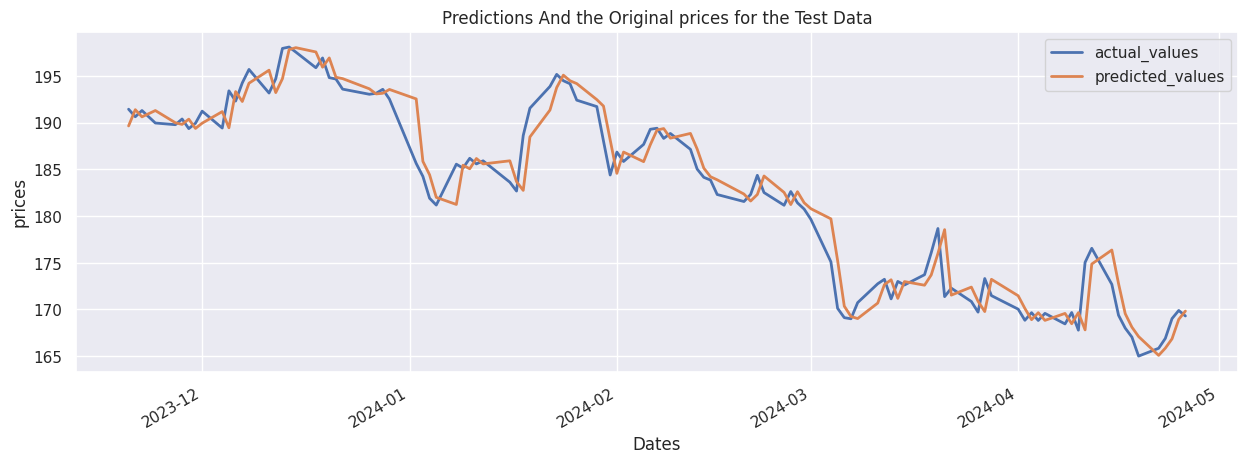

In [ ]:
sns.set(rc = {'figure.figsize': (15, 5)})
result_df['actual_values'].plot(linewidth =2)
result_df['predicted_values'].plot(linewidth =2)

# label chart
plt.xlabel('Dates')
plt.ylabel('prices')
plt.title('Predictions And the Original prices for the Test Data')
plt.legend();

It proposes that two distinct methodologies, namely the forecasting approach and the standard prediction technique, are employed to predict test data. Upon evaluating both methods, it is observed that the normal prediction technique demonstrates superior predictive accuracy, as evidenced by its lower mean absolute error in comparison to the forecasting method.

### Future Forecasting

In [ ]:
# Define the number of days to forecast
forecast_days = 10

from datetime import datetime, timedelta

# Generate future dates for the forecast period
last_date = data.index[-1]  # Last date in your dataset
future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=forecast_days)

# Function to check if a date is a weekend (Saturday or Sunday)
def is_weekend(date):
    return date.weekday() >= 5  # Saturday and Sunday have weekday() values of 5 and 6

# Exclude weekends from the forecasted dates
future_dates_excluding_weekends = [date for date in future_dates if not is_weekend(date)]

# Forecast prices for the non-weekend dates
fitted_model = model.fit()
forecasted_prices = fitted_model.forecast(steps=len(future_dates_excluding_weekends))

# Create a DataFrame with the forecasted prices and non-weekend dates as the index
forecast_df = pd.DataFrame({'price': forecasted_prices}, index=future_dates_excluding_weekends)

forecast_df

                 price
2024-04-29  169.823643
2024-04-30  169.808738
2024-05-01  169.810456
2024-05-02  169.810694
2024-05-03  169.810654
2024-05-06  169.810651


## Forecasting with LSTM 

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [ ]:
scaled_prices=scaler.fit_transform(data[["Close"]].values)
import numpy as np
#Split data into Training and Test sets
total_size = len(scaled_prices)


train_reshaped = np.array(train).reshape(-1, 1)
test_reshaped = np.array(test).reshape(-1, 1)
scaler.fit(train_reshaped)
scaler.fit(train_reshaped)
scaled_train = scaler.transform(train_reshaped)
scaled_test = scaler.transform(test_reshaped)

In [ ]:
scaled_train[:10]

array([[0.13533301],
       [0.13013198],
       [0.13435334],
       [0.13184194],
       [0.14039152],
       [0.15186223],
       [0.15310901],
       [0.16491815],
       [0.15729476],
       [0.15490801]])

In [ ]:
#@title Prepare RNN Dataset.
#Each data point (X) is linked to the previous data points of size=lookback
#The predicted value (Y) is the next point
def create_rnn_dataset(data, lookback=1):

    data_x, data_y = [], []
    for i in range((len(data)- lookback -1)):
            #All points from this point, looking backwards upto lookback
            a = data[i:(i+ lookback), 0]
            data_x.append(a)
            #The next point
            data_y.append(data[i + lookback, 0])
    return np.array(data_x), np.array(data_y)

#lookback for 25 previous days
lookback=25

#Create X and Y for training
train_req_x, train_req_y = create_rnn_dataset(scaled_train,lookback)

#Reshape for use with RNN
train_req_x = np.reshape(train_req_x,
                         (train_req_x.shape[0],1, train_req_x.shape[1]))

print("Shapes of X, Y: ",train_req_x.shape, train_req_y.shape)

Shapes of X, Y:  (952, 1, 25) (952,)


In [ ]:
from keras.models import Sequential
from keras.layers import LSTM,Dense
import tensorflow as tf

tf.random.set_seed(3)

#Create a Keras Model
price_model=Sequential()
#Add Simple RNN layer with 32 nodes
price_model.add(LSTM(128, input_shape=(1,lookback)))
#Add a Dense layer at the end for output
price_model.add(Dense(1))

#Compile with Adam Optimizer. Optimize for minimum mean square error
price_model.compile(loss="mean_squared_error",
                 optimizer="adam",
                 metrics=["mse"])

#Print model summary
price_model.summary()

#Train the model
price_model.fit(train_req_x, train_req_y,
             epochs=5, batch_size=1, verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               78848     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 78977 (308.50 KB)
Trainable params: 78977 (308.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
952/952 [==============================] - 6s 3ms/step - loss: 0.0032 - mse: 0.0032
Epoch 2/5
952/952 [==============================] - 3s 3ms/step - loss: 0.0014 - mse: 0.0014
Epoch 3/5
952/952 [==============================] - 3s 3ms/step - loss: 0.0012 - mse: 0.0012
Epoch 4/5
952/952 [==============================] - 4s 4ms/step - loss: 0.0013 - mse: 0.0013
Epoch 5/5
952/952 [===================

In [ ]:
#@title Preprocess the test dataset, the same way training set is processed
test_req_x, test_req_y = create_rnn_dataset(scaled_test,lookback)

print(test_req_x.shape, test_req_y.shape)

test_req_x = np.reshape(test_req_x,
                         (test_req_x.shape[0],1, test_req_x.shape[1]))

#Evaluate the model
price_model.evaluate(test_req_x, test_req_y, verbose=1)

#Predict on the test dataset
predict_on_test = price_model.predict(test_req_x)

#Inverse the scaling to view results
predict_on_test = scaler.inverse_transform(predict_on_test)

(83, 25) (83,)
3/3 [==============================] - 0s 5ms/step


### Predicting for the Test data

In [ ]:
#Extract original test values that map to the same dates on the predicted test values
orig_test_values = data[["Close"]].iloc[total_size - len(predict_on_test):]
orig_test_values.reset_index(drop=True, inplace=True)

# Flatten the arrays
y_test_flat = orig_test_values.values.flatten()
predictions_flat = predict_on_test.flatten()

# Get the index of the original test values DataFrame
time_index = data.index[total_size - len(predict_on_test):]

# Convert the index to a datetime index
time_index = pd.to_datetime(time_index)

# Replace the index of orig_test_values DataFrame with the datetime index
orig_test_values.index = time_index

# Create the DataFrame
df_predictions = pd.DataFrame({"Original Prices": y_test_flat, "Predicted Prices": predictions_flat}, index=orig_test_values.index)

# calculate mean_absolute error
mae = mean_absolute_error(y_test_flat, predictions_flat)
print("The mean absolute error is", round(mae, 2))

# Output the DataFrame
print(df_predictions)

The mean absolute error is 2.97
            Original Prices  Predicted Prices
Date                                         
2023-12-28       193.580002        191.481079
2023-12-29       192.529999        191.024307
2024-01-02       185.639999        190.891602
2024-01-03       184.250000        190.555695
2024-01-04       181.910004        188.238419
...                     ...               ...
2024-04-22       165.839996        168.867783
2024-04-23       166.899994        167.743423
2024-04-24       169.020004        167.008194
2024-04-25       169.889999        166.621445
2024-04-26       169.300003        167.243546

[83 rows x 2 columns]


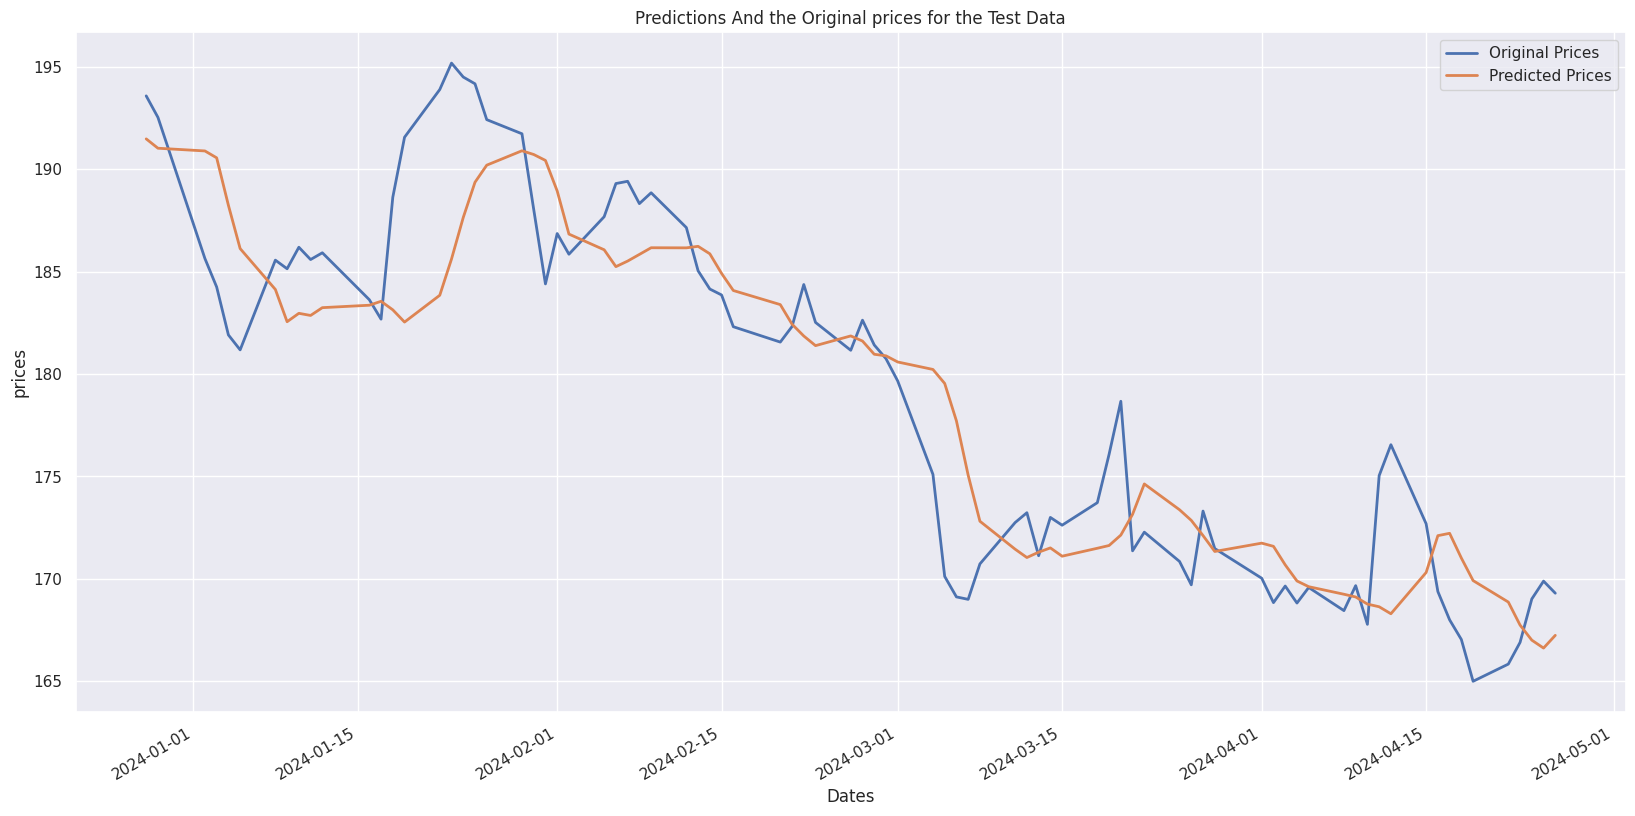

In [ ]:
sns.set(rc = {'figure.figsize': (20, 10)})
df_predictions['Original Prices'].plot(linewidth =2)
df_predictions['Predicted Prices'].plot(linewidth =2)

# label chart
plt.xlabel('Dates')
plt.ylabel('prices')
plt.title('Predictions And the Original prices for the Test Data')
plt.legend();

### Future Forecasting

In [ ]:
#Use last part of the training data as the initial lookback
curr_input= test_req_x[-1,:].flatten()

#Predict for the next week
predict_for = 10

for i in range(predict_for):

    #Take the last lookback no. of samples as X
    this_input=curr_input[-lookback:]
    #Create the input
    this_input=this_input.reshape((1,1,lookback))
    #Predict for the next point
    this_prediction=price_model.predict(this_input)

    #Add the current prediction to the input
    curr_input = np.append(curr_input,this_prediction.flatten())

#Extract the last predict_for part of curr_input, which contains all the new predictions
predict_on_future=np.reshape(np.array(curr_input[-predict_for:]),(predict_for,1))

# #Inverse to view results
predict_on_future=scaler.inverse_transform(predict_on_future)

# Flatten the arrays
y_forcast_flat = predict_on_future.flatten()

y_forcast_flat

1/1 [==============================] - 0s 126ms/step


array([167.24354792, 167.18733704, 166.92997505, 166.97495881,
       166.76380201, 166.58055405, 166.47301801, 166.35897326,
       166.2371147 , 166.11267107])

In [ ]:
from datetime import datetime, timedelta
import pandas as pd

# Define the last date in your existing data
last_date = "2024-04-26"  # Replace this with the actual last date in your existing data

# Define the number of days to predict
predict_for = 10

# Initialize an empty list to store future dates
future_dates = []

# Convert the last date to a datetime object
last_date = datetime.strptime(last_date, "%Y-%m-%d")

# Function to check if a date is a weekend (Saturday or Sunday)
def is_weekend(date):
    return date.weekday() >= 5  # Saturday and Sunday have weekday() values of 5 and 6

# Iterate over the number of days to predict
days_predicted = 0
current_date = last_date + timedelta(days=1)  # Start from the next day after the last date
while days_predicted < predict_for:
    # Check if the current date is not a weekend
    if not is_weekend(current_date):
        # Append the current date to the list of future dates
        future_dates.append(current_date)
        days_predicted += 1  # Increment the number of days predicted
    # Move to the next day
    current_date += timedelta(days=1)

# Flatten the arrays
y_forecast_flat = predict_on_future.flatten()

# Create a DataFrame with the forecasted prices and future dates as the index
forecast_df = pd.DataFrame({'price': y_forecast_flat}, index=future_dates)

forecast_df

,price
2024-04-29,167.243548
2024-04-30,167.187337
2024-05-01,166.929975
2024-05-02,166.974959
2024-05-03,166.763802
2024-05-06,166.580554
2024-05-07,166.473018
2024-05-08,166.358973
2024-05-09,166.237115
2024-05-10,166.112671
